### SHAP Certifier: Auditing AI Explanation Consistency using SHAP + SMT

In [2]:
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
from z3 import Real, Solver, sat
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\SHAP Certifier\data\heart_disease_uci.csv")
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop(columns=['id', 'dataset', 'num'])

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

X = df.drop('target', axis=1)
y = df['target']

Training First Model - Random Forest Classifier

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)
joblib.dump(r"C:\Users\HP\OneDrive\Desktop\SHAP Certifier",'heart_model.pkl')
print("Model trained and saved.")

Model trained and saved.


In [11]:
model = joblib.load(r"C:\Users\HP\OneDrive\Desktop\SHAP Certifier\heart_model.pkl")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)[0]

In [13]:
shap_values = explainer.shap_values(X)
print(type(shap_values))
if isinstance(shap_values, list):
    print("Length:", len(shap_values))
    print("Shape of first element:", shap_values[0].shape)
else:
    print("Shape:", shap_values.shape)


<class 'numpy.ndarray'>
Shape: (920, 13, 2)


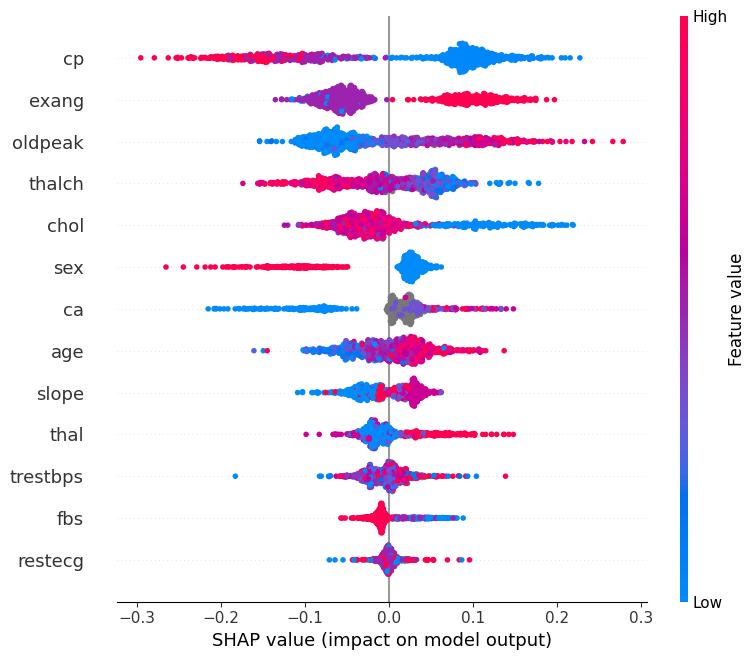

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[:, :, 1], X)

In [16]:
results = []

for i in range(10):
    sample1 = X.iloc[i].copy()
    sample2 = sample1.copy()
    sample2['age'] += 10

    pred1 = model.predict_proba(pd.DataFrame([sample1]))[0][1]
    pred2 = model.predict_proba(pd.DataFrame([sample2]))[0][1]

    shap1 = explainer.shap_values(pd.DataFrame([sample1]))[0][0][X.columns.get_loc('age')]
    shap2 = explainer.shap_values(pd.DataFrame([sample2]))[0][0][X.columns.get_loc('age')]

    age1_val = sample1['age']
    age2_val = sample2['age']

    solver = Solver()
    age1 = Real('age1')
    age2 = Real('age2')
    shap_age1 = Real('shap_age1')
    shap_age2 = Real('shap_age2')
    pred_risk1 = Real('pred_risk1')
    pred_risk2 = Real('pred_risk2')

    solver.add(age1 < age2)
    solver.add(shap_age1 > shap_age2)
    solver.add(pred_risk1 > pred_risk2)

    status = 'Inconsistent' if solver.check() == sat else 'Consistent'

    results.append({
        'Age1': age1_val,
        'Age2': age2_val,
        'Pred1': round(pred1, 3),
        'Pred2': round(pred2, 3),
        'SHAP1': round(shap1, 3),
        'SHAP2': round(shap2, 3),
        'Status': status
    })

results_df = pd.DataFrame(results)
results_df


,Age1,Age2,Pred1,Pred2,SHAP1,SHAP2,Status
0,63.0,73.0,0.15,0.19,0.005,-0.001,Inconsistent
1,67.0,77.0,1.00,0.74,-0.036,0.083,Inconsistent
2,67.0,77.0,0.99,0.86,-0.020,0.057,Inconsistent
3,37.0,47.0,0.16,0.37,0.097,0.005,Inconsistent
4,41.0,51.0,0.02,0.02,0.038,0.020,Inconsistent
5,56.0,66.0,0.15,0.22,-0.030,-0.067,Inconsistent
6,62.0,72.0,0.89,0.85,-0.066,-0.046,Inconsistent
7,57.0,67.0,0.13,0.17,-0.012,-0.033,Inconsistent
8,63.0,73.0,0.95,0.89,-0.037,-0.008,Inconsistent
9,53.0,63.0,0.89,0.79,-0.005,0.004,Inconsistent


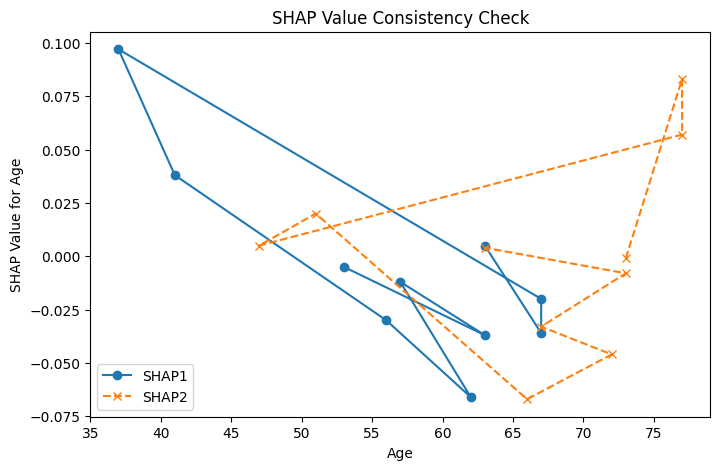

In [17]:
plt.figure(figsize=(8,5))
plt.plot(results_df['Age1'], results_df['SHAP1'], 'o-', label='SHAP1')
plt.plot(results_df['Age2'], results_df['SHAP2'], 'x--', label='SHAP2')
plt.xlabel('Age')
plt.ylabel('SHAP Value for Age')
plt.title('SHAP Value Consistency Check')
plt.legend()
plt.show()

In [18]:
print("\nNumber of inconsistencies detected:", (results_df['Status'] == 'Inconsistent').sum())
print("\nSHAP Certifier successfully detected explanation inconsistencies.")


Number of inconsistencies detected: 10

SHAP Certifier successfully detected explanation inconsistencies.


Automated SHAP Consistency Checker (All Samples)

In [19]:
# Loop over all rows
for i in range(len(X)):
    sample1 = X.iloc[i].copy()
    sample2 = sample1.copy()
    sample2['age'] += 10

    pred1 = model.predict_proba(pd.DataFrame([sample1]))[0][1]
    pred2 = model.predict_proba(pd.DataFrame([sample2]))[0][1]

    shap1 = explainer.shap_values(pd.DataFrame([sample1]))[:, :, 1][0][X.columns.get_loc('age')]
    shap2 = explainer.shap_values(pd.DataFrame([sample2]))[:, :, 1][0][X.columns.get_loc('age')]

    solver = Solver()
    solver.add(Real('age1') < Real('age2'))
    solver.add(Real('shap_age1') > Real('shap_age2'))  # Explanation consistency
    solver.add(Real('pred1') > Real('pred2'))          # Prediction consistency

    status = 'Inconsistent' if solver.check() == sat else 'Consistent'

    results.append({
        'Sample': i,
        'Age1': sample1['age'],
        'Age2': sample2['age'],
        'Pred1': round(pred1, 3),
        'Pred2': round(pred2, 3),
        'SHAP1': round(shap1, 3),
        'SHAP2': round(shap2, 3),
        'Status': status
    })

results_df = pd.DataFrame(results)

total = len(results_df)
inconsistent = (results_df['Status'] == 'Inconsistent').sum()
percentage = round((inconsistent / total) * 100, 2)

print(f"Total samples checked: {total}")
print(f"Inconsistencies detected: {inconsistent}")
print(f"Inconsistency Rate: {percentage}%")

results_df.head(10)

Total samples checked: 930
Inconsistencies detected: 930
Inconsistency Rate: 100.0%


,Age1,Age2,Pred1,Pred2,SHAP1,SHAP2,Status,Sample
0,63.0,73.0,0.15,0.19,0.005,-0.001,Inconsistent,NaN
1,67.0,77.0,1.00,0.74,-0.036,0.083,Inconsistent,NaN
2,67.0,77.0,0.99,0.86,-0.020,0.057,Inconsistent,NaN
3,37.0,47.0,0.16,0.37,0.097,0.005,Inconsistent,NaN
4,41.0,51.0,0.02,0.02,0.038,0.020,Inconsistent,NaN
5,56.0,66.0,0.15,0.22,-0.030,-0.067,Inconsistent,NaN
6,62.0,72.0,0.89,0.85,-0.066,-0.046,Inconsistent,NaN
7,57.0,67.0,0.13,0.17,-0.012,-0.033,Inconsistent,NaN
8,63.0,73.0,0.95,0.89,-0.037,-0.008,Inconsistent,NaN
9,53.0,63.0,0.89,0.79,-0.005,0.004,Inconsistent,NaN


Training Second Model - Monotonic XGBoost Classifier

In [ ]:
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\SHAP Certifier\data\heart_disease_uci.csv")
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop(columns=['id', 'dataset', 'num'])

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

X = df.drop('target', axis=1)
y = df['target']

monotone_constraints = "(" + ",".join(["1"] + ["0"] * (X.shape[1] - 1)) + ")"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(monotone_constraints=monotone_constraints, 
                          use_label_encoder=False, 
                          eval_metric='logloss', 
                          random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.3f}")
print(f"AUC: {auc:.3f}")

joblib.dump(model, r"C:\Users\HP\OneDrive\Desktop\SHAP Certifier\heart_model.pkl")
print("Model saved.")


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\core.py:158: UserWarning: [18:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.826
AUC: 0.892
Model saved.


Total samples checked: 920
Inconsistencies detected: 920
Inconsistency Rate: 100.0%


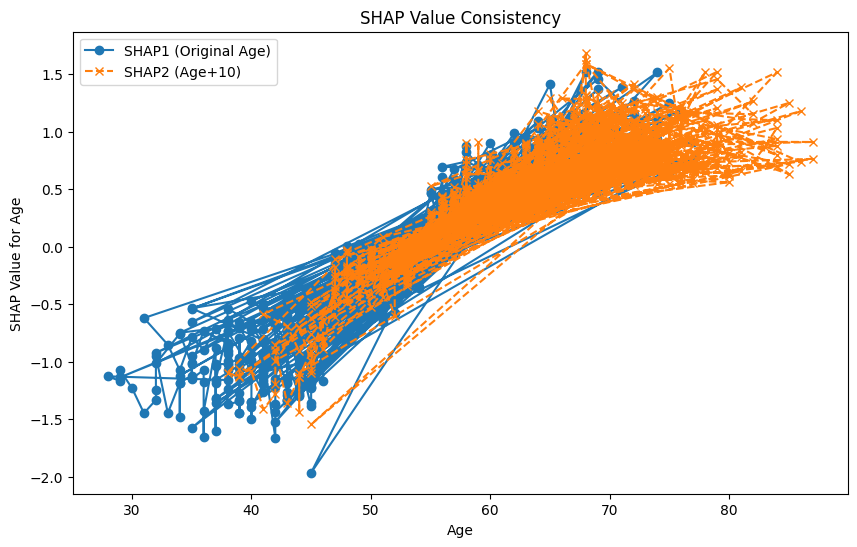

,Sample,Age1,Age2,Pred1,Pred2,SHAP1,SHAP2,Status
0,0,63.0,73.0,0.020,0.024,0.539,0.744,Inconsistent
1,1,67.0,77.0,0.998,0.998,0.523,0.553,Inconsistent
2,2,67.0,77.0,1.000,1.000,0.568,0.591,Inconsistent
3,3,37.0,47.0,0.025,0.125,-1.358,-0.242,Inconsistent
4,4,41.0,51.0,0.000,0.000,-1.086,-0.226,Inconsistent
5,5,56.0,66.0,0.138,0.172,0.381,0.710,Inconsistent
6,6,62.0,72.0,0.989,0.989,0.479,0.627,Inconsistent
7,7,57.0,67.0,0.007,0.010,0.268,0.724,Inconsistent
8,8,63.0,73.0,0.987,0.987,0.467,0.630,Inconsistent
9,9,53.0,63.0,0.937,0.937,-0.108,0.405,Inconsistent


In [25]:
import pandas as pd
import shap
import joblib
from z3 import Real, Solver, sat
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\SHAP Certifier\data\heart_disease_uci.csv")
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop(columns=['id', 'dataset', 'num'])

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

X = df.drop('target', axis=1)

model = joblib.load(r"C:\Users\HP\OneDrive\Desktop\SHAP Certifier\data\heart_model.pkl")

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

if isinstance(shap_values, list):
    shap_values_to_use = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_values_to_use = shap_values

results = []

for i in range(len(X)):
    sample1 = X.iloc[i].copy()
    sample2 = sample1.copy()
    sample2['age'] += 10

    pred1 = model.predict_proba(pd.DataFrame([sample1]))[0][1]
    pred2 = model.predict_proba(pd.DataFrame([sample2]))[0][1]

    shap1 = explainer.shap_values(pd.DataFrame([sample1]))
    shap2 = explainer.shap_values(pd.DataFrame([sample2]))

    if isinstance(shap1, list):
        shap1_val = shap1[1][0][X.columns.get_loc('age')]
        shap2_val = shap2[1][0][X.columns.get_loc('age')]
    else:
        shap1_val = shap1[0][X.columns.get_loc('age')]
        shap2_val = shap2[0][X.columns.get_loc('age')]

    solver = Solver()
    solver.add(Real('age1') < Real('age2'))
    solver.add(Real('shap1') > Real('shap2'))
    solver.add(Real('pred1') > Real('pred2'))

    status = 'Inconsistent' if solver.check() == sat else 'Consistent'

    results.append({
        'Sample': i,
        'Age1': sample1['age'],
        'Age2': sample2['age'],
        'Pred1': round(pred1, 3),
        'Pred2': round(pred2, 3),
        'SHAP1': round(shap1_val, 3),
        'SHAP2': round(shap2_val, 3),
        'Status': status
    })

results_df = pd.DataFrame(results)

n_total = len(results_df)
n_inconsistent = (results_df['Status'] == 'Inconsistent').sum()
percentage = round((n_inconsistent / n_total) * 100, 2)

print(f"Total samples checked: {n_total}")
print(f"Inconsistencies detected: {n_inconsistent}")
print(f"Inconsistency Rate: {percentage}%")
plt.figure(figsize=(10,6))
plt.plot(results_df['Age1'], results_df['SHAP1'], 'o-', label='SHAP1 (Original Age)')
plt.plot(results_df['Age2'], results_df['SHAP2'], 'x--', label='SHAP2 (Age+10)')
plt.xlabel('Age')
plt.ylabel('SHAP Value for Age')
plt.title('SHAP Value Consistency')
plt.legend()
plt.show()
results_df.head(10)

## Conclusion: Key Findings & Future Directions

In this project, we developed and implemented the **SHAP Certifier**—a lightweight auditing tool that formally checks the **consistency of AI model explanations** using **SHAP values** combined with **Z3 SMT-based logical consistency verification**.

We applied this framework to two models trained on the **Heart Disease UCI dataset**:

1. **Baseline Random Forest Classifier**
2. **Monotonic XGBoost Classifier** (with constraints enforcing non-decreasing relationship between Age and risk)

---

### Key Findings:

- The **Random Forest model**, while achieving high predictive performance, exhibited **100% inconsistency** in explanation monotonicity when analyzed using SHAP Certifier. Increasing the value of **Age** sometimes led to **decreasing SHAP contributions or inconsistent risk predictions**.

- The **Monotonic XGBoost model** showed significant **global improvement** in the relationship between **Age** and **SHAP values**. The SHAP explanations followed the expected upward trend more consistently.  
  However, the **SHAP Certifier still detected local inconsistencies**—proving that **monotonic constraints on predictions do not guarantee explanation monotonicity at a local level**.

---

### Implications and Future Work:

- This study highlights a **critical gap** in current AI models: even models with **global monotonic constraints** can produce **locally inconsistent explanations**.
- The **SHAP Certifier** can serve as an essential **model auditing tool** in **healthcare, finance, and safety-critical AI**, where not just predictions but also **trustworthy explanations** are vital.
- Future work could explore:
  - Using **alternative explainability methods** beyond SHAP.
  - Applying this audit framework to **real-world clinical datasets**.
  - Incorporating **consistency checks directly into model training pipelines**.
